In [211]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# this is the size of our encoded representations
encoding_dim = 3  # 3 floats -> compression of factor 24.5, assuming the input is 7 floats
batch_size = 10
epochs = 50


# this is our input placeholder
input_img = Input(shape=(7,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(7, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [212]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [213]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [214]:
df = pd.read_excel("test.xlsx") #считываю инф с файла

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 7 columns):
a    10000 non-null float64
b    10000 non-null float64
c    10000 non-null int64
d    10000 non-null float64
e    10000 non-null float64
f    10000 non-null int64
g    10000 non-null float64
dtypes: float64(5), int64(2)
memory usage: 625.0 KB


In [216]:
df_norm = (df) / (df.max())

In [217]:
df_norm.shape

(10000, 7)

In [218]:
x_train_= df_norm.values
x_test_= df_norm.values

x_train = np.reshape(x_train_, (len(x_train_), 7))
x_test  = np.reshape(x_test_,  (len(x_test_), 7))

In [219]:
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [220]:
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

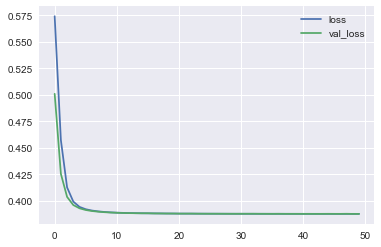

In [221]:
from keras.callbacks import TensorBoard

h = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks = [plot_losses],
                verbose=0)


In [222]:
print(h.history)


{'val_loss': [0.5009445573985577, 0.42538408476114276, 0.40359015327692033, 0.39590619415044787, 0.39282703191041946, 0.3912222128212452, 0.39025043475627902, 0.38964452400803568, 0.38916451662778856, 0.38883952161669733, 0.38860482102632521, 0.38840195497870444, 0.38828451907634737, 0.38820608204603196, 0.38813379815220833, 0.38816411384940147, 0.38797606682777402, 0.38796052128076552, 0.38787922769784927, 0.38788774448633195, 0.38780021253228186, 0.38780046463012696, 0.38782890826463701, 0.38774554398655892, 0.38771079695224764, 0.3877011575996876, 0.38769765824079516, 0.38767463237047195, 0.38765296211838723, 0.38764520055055618, 0.38766070070862768, 0.38766265076398848, 0.38768644970655441, 0.38763429883122447, 0.38761509203910827, 0.38758952432870863, 0.38763216048479082, 0.38758610463142396, 0.38758515718579295, 0.38759121534228325, 0.38756654861569406, 0.38758118519186974, 0.38754621055722238, 0.38757103005051613, 0.38761502584815027, 0.38757883957028388, 0.3875717339217663, 0.3

In [223]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [224]:
print (x_test[1], decoded_imgs[1])

[ 0.26043577  0.30600718  1.          0.27987021  0.28964705  0.5
  0.32470805] [ 0.24059753  0.28461015  1.          0.27000335  0.26885232  0.52903867
  0.31045312]


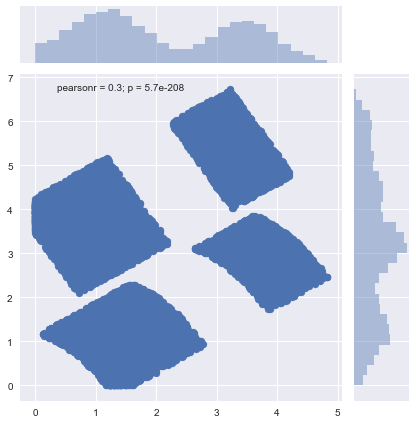

In [226]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))

sns.jointplot(x_test_encoded[:, 0], x_test_encoded[:, 2])

In [233]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

x = x_test_encoded[:, 0]
y = x_test_encoded[:, 1]
z = x_test_encoded[:, 2]
#x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 400).transpose()

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link = False)